# Example: Hydrologic Conditioning with a focus on stream mesh


In [14]:
# conda package imports
import numpy as np
from matplotlib import pyplot as plt
import logging
import copy
import shapely

import watershed_workflow 
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.crs
import watershed_workflow.densification
import watershed_workflow.mesh
import watershed_workflow.condition
watershed_workflow.ui.setup_logging(1,None)

%matplotlib ipympl

In [2]:
## Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed. 
coweeta_shapefile = '../../Coweeta_data/input_data/coweeta_basin.shp'
hint = '0601'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape
name = 'Coweeta'

figsize = (6,6)
figsize_3d = (8,6)

# Geomtric parameters tuning the degree of cleaning of the raw data and scales of hydrologic features to be considered
simplify = 60 # length scale to target average edge
ignore_small_rivers = 2 
prune_by_area_fraction = 0.01 

# huc boundary refinement control
refine_d0 = 20
refine_d1 = 100
refine_L0 = 70
refine_L1 = 200

In [3]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.daymet_crs()

### Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [4]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.get_default_sources()
sources['hydrography'] = watershed_workflow.source_list.hydrography_sources['NHD Plus']
sources['HUC'] = watershed_workflow.source_list.huc_sources['NHD Plus']
sources['DEM'] = '../../Coweeta_data/input_data/DEM/coweeta_dem.tif'

### Get HUCs

In [5]:
# load hucs from shape
_, watershed = watershed_workflow.get_split_form_shapes(coweeta_shapefile, out_crs=crs)

2024-11-10 19:13:08,151 - root - INFO: 
2024-11-10 19:13:08,152 - root - INFO: Loading shapes
2024-11-10 19:13:08,152 - root - INFO: ------------------------------
2024-11-10 19:13:08,152 - root - INFO: Loading file: '../../Coweeta_data/input_data/coweeta_basin.shp'
2024-11-10 19:13:08,164 - root - INFO: ... found 1 shapes
2024-11-10 19:13:08,165 - root - INFO: Converting to shapely
2024-11-10 19:13:08,166 - root - INFO:  ... done
2024-11-10 19:13:08,167 - root - INFO: Converting to requested CRS
2024-11-10 19:13:08,174 - root - INFO:  ... done
2024-11-10 19:13:08,175 - root - INFO: Removing holes on 1 polygons
2024-11-10 19:13:08,175 - root - INFO:   -- removed interior
2024-11-10 19:13:08,176 - root - INFO:   -- union
2024-11-10 19:13:08,176 - root - INFO: Parsing 1 components for holes
2024-11-10 19:13:08,176 - root - INFO:   -- complete


### Get Rivers 

In [6]:
include_rivers=True

if include_rivers:  
    # download/collect the river network within that shape's bounds
    _, reaches = watershed_workflow.get_reaches(sources['hydrography'], hint, 
                                                watershed.exterior(), crs, crs,
                                                in_network=True, properties=True)
    
    rivers = watershed_workflow.construct_rivers(reaches, method='hydroseq',
                                                 ignore_small_rivers=ignore_small_rivers,
                                                 prune_by_area=prune_by_area_fraction * watershed.exterior().area * 1.e-6,
                                                 remove_diversions=True,
                                                 remove_braided_divergences=True)
    
    # keeping the originals
    rivers_orig=[river.deepcopy() for river in rivers]
    watershed_orig=copy.deepcopy(watershed) 
    
    # simplifying 
    rivers = watershed_workflow.simplify(watershed, rivers, simplify_hucs=simplify, simplify_rivers=simplify,
                               snap_tol=0.75*simplify, cut_intersections=True)
    
    # for plotting purpose only
    rivers_simplified=[river.deepcopy() for river in rivers] 
    watershed_simplified=copy.deepcopy(watershed) 

else:
    reaches = []
    rivers = []

2024-11-10 19:13:08,183 - root - INFO: 
2024-11-10 19:13:08,184 - root - INFO: Loading Hydrography
2024-11-10 19:13:08,184 - root - INFO: ------------------------------
2024-11-10 19:13:08,184 - root - INFO: Loading streams in HUC 0601
2024-11-10 19:13:08,185 - root - INFO:          and/or bounds (1442132.8431974081, -650282.0481837074, 1447117.7928619597, -645090.2638397979)
2024-11-10 19:13:08,185 - root - INFO:   Using Hydrography file "/Users/7s2/Research/watershed_workflow_data/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb"
2024-11-10 19:13:08,186 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening '/Users/7s2/Research/watershed_workflow_data/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb' layer 'NHDFlowline' for streams in '(1442132.8431974081, -650282.0481837074, 1447117.7928619597, -645090.2638397979)'
2024-11-10 19:13:09,041 - root - INFO:   Found total of 44 in bounds.
2024-11-10 19:13:09,042 - root - INFO: Filtering reaches not in-

### Densification of River Network and Watershed

In [7]:
d0 = refine_d0; d1 = refine_d1
L0 = refine_L0; L1 = refine_L1 

# densify_watershed
watershed_workflow.densification.densify_hucs(watershed, watershed_orig, rivers, limit_scales=[d0,L0,d1,L1]) 

#densify_river
watershed_workflow.densification.densify_rivers_new(rivers, limit=70)


# treat sharp angles
watershed_workflow.densification.remove_sharp_angles(rivers, watershed, angle_limit=10, junction_angle_limit=10, huc_seg_river_angle_limit=10, limit=70)

2024-11-10 19:13:14,441 - root - INFO:   river min seg length: 61.98201607276061
2024-11-10 19:13:14,441 - root - INFO:   river median seg length: 68.58412894200525


2024-11-10 19:13:14,476 - root - INFO: removing sharp angle between river and huc: 9.328301133171266 for node 25000400040729


/Users/7s2/opt/anaconda3/envs/watershed_workflow-pure/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


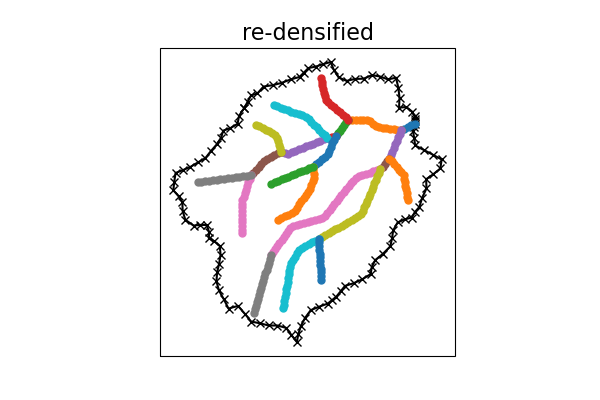

In [8]:
# plot re-densified watershed and river network
fig, ax = plt.subplots(subplot_kw={'projection':watershed_workflow.crs.to_cartopy(crs)}, figsize=(6,4))

ax.plot(watershed.exterior().exterior.xy[0], watershed.exterior().exterior.xy[1], 'k-x')
ax.set_title('re-densified',fontsize=16)

for river in rivers:
    for node in river.preOrder():
        x,y=node.segment.xy 
        ax.plot(x,y,'-o',markersize=5)
plt.show()

In [9]:
# how many types of Stream Orders are there
set([r.properties["StreamOrder"] for r in rivers[0].preOrder()])

{1, 2, 3}

## Meshing

2024-11-10 19:13:14,767 - root - INFO: 
2024-11-10 19:13:14,767 - root - INFO: Stream-aligned Meshing
2024-11-10 19:13:14,767 - root - INFO: ------------------------------
2024-11-10 19:13:14,768 - root - INFO: treat stream triangles is set to None
2024-11-10 19:13:14,768 - root - INFO: Creating stream-aligned mesh...
2024-11-10 19:13:14,768 - root - INFO: River 0
2024-11-10 19:13:14,769 - root - INFO: ... generating initial polygon through dilation (4 m)
2024-11-10 19:13:14,772 - root - INFO:   -- treating collinearity
2024-11-10 19:13:14,777 - root - INFO:   -- river min seg length: 61.98201607276061
2024-11-10 19:13:14,777 - root - INFO:   -- merging points closer than 45.98201607276061 m along the river corridor
2024-11-10 19:13:14,782 - root - INFO: ... defining river-mesh topology (quad elements)
2024-11-10 19:13:14,818 - root - INFO: ... setting width of quad elements
2024-11-10 19:13:14,824 - root - INFO: ... enforcing convexity
2024-11-10 19:13:14,830 - root - INFO: Adjusting 

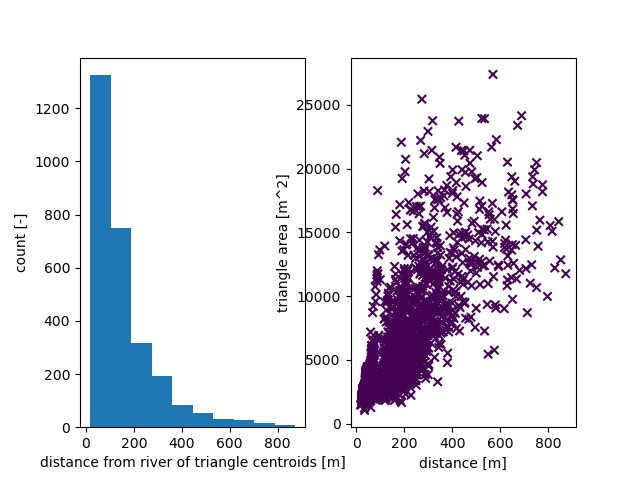

In [10]:
## Triangulation

# Refine triangles if they get too acute
min_angle = 32 # degrees

# width of reach by stream order (order:width)
widths = dict({1:8,2:12,3:16})

mesh_points2, conn_list, areas, dists = watershed_workflow.tessalate_river_aligned(watershed,rivers, river_width=widths,
                                              refine_min_angle=min_angle, refine_max_area=30000,
                                              diagnostics=True)

# try refine area = 10000, 20000 and 50000


In [17]:
# get a raster for the elevation map, based on NED
dem_profile, dem = watershed_workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

# elevate the triangle nodes to the dem
mesh_points3 = watershed_workflow.elevate(mesh_points2, crs, dem, dem_profile)

# construct the 2D mesh
m2 = watershed_workflow.mesh.Mesh2D(mesh_points3.copy(), conn_list)

2024-11-10 19:15:14,077 - root - INFO: 
2024-11-10 19:15:14,079 - root - INFO: Loading Raster
2024-11-10 19:15:14,079 - root - INFO: ------------------------------
2024-11-10 19:15:14,079 - root - INFO: Loading file: '../../Coweeta_data/input_data/DEM/coweeta_dem.tif'
2024-11-10 19:15:14,080 - root - INFO: Collecting raster
2024-11-10 19:15:14,088 - root - INFO: bounds in my_crs: (-83.47845037186387, 35.02734099944037, -83.42165773504303, 35.07381933600275)
2024-11-10 19:15:14,089 - root - INFO: ... got raster of shape: (169, 206)
2024-11-10 19:15:14,090 - root - INFO: ... got raster bounds: (-83.47872814964133, 35.074097113780205, -83.4215059274172, 35.0271526693342)


In [18]:
# save a copy of the unconditioned mesh
m2_unconditioned = copy.deepcopy(m2)

kwargs =  {'linewidth': 0.5, 'cmap': <matplotlib.colors.ListedColormap object at 0x305730af0>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x305730b50>, 'edgecolor': 'k'}
setting face color =  [1341.90253697  692.39893454  777.7524677  ...  874.57965231  886.21624931
  896.01467586]


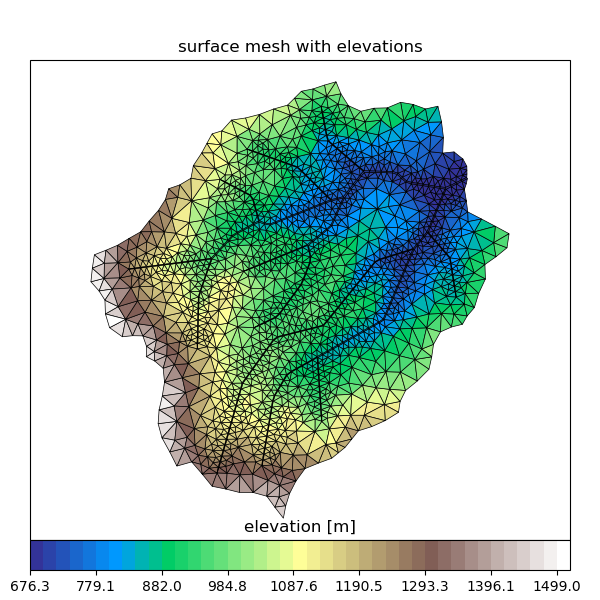

In [20]:
# plotting surface mesh with elevations
start=min(m2_unconditioned.centroids[:,2])
step=(max(m2_unconditioned.centroids[:,2])-(min(m2_unconditioned.centroids[:,2])))/40
stop=max(m2_unconditioned.centroids[:,2])+step
legend_values=np.arange(start,stop,step)
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(legend_values, cmap='terrain')


fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

mp = watershed_workflow.plot.mesh(m2_unconditioned, crs, ax=ax, 
                        linewidth=0.5 ,color=m2_unconditioned.centroids[:,2], 
                        cmap=cmap, norm = norm, edgecolor='k', facecolor='color')
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
ax.set_title('surface mesh with elevations')
ax.set_aspect('equal', 'datalim')

cbar.ax.set_title('elevation [m]')

plt.show()


## Pit-filling

In the <b>pit-filling</b> algorithm, we want to make sure that river corridor is not filled up. Hence we exclude river corridor cells from the pit-filling algorithm.

In [22]:
# removing pits
river_mask=np.zeros((len(m2.conn)))
for i, elem in enumerate(m2.conn):
    if not len(elem)==3:
        river_mask[i]=1
watershed_workflow.condition.fill_pits_dual(m2, is_waterbody=river_mask)

max diff =  5.263464049176491
kwargs =  {'linewidth': 0.5, 'cmap': <matplotlib.colors.ListedColormap object at 0x30656fb50>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x30656fbe0>, 'edgecolor': 'k'}
setting face color =  [0.        0.        0.        ... 2.1316488 2.1316488 0.       ]


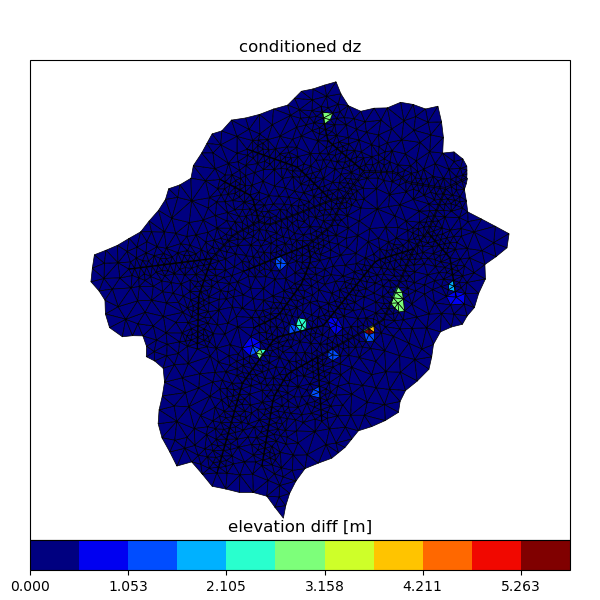

In [23]:
# plot the change between the two meshes
diff = m2.centroids[:,2] - m2_unconditioned.centroids[:,2]
print("max diff = ", np.abs(diff).max())

# plotting surface mesh with elevations
start=min(diff)
step=(max(diff)-(min(diff)))/10
stop=max(diff)+step
legend_values=np.arange(start,stop,step)
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(legend_values, cmap='jet')


fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])
mp = watershed_workflow.plot.mesh(m2, crs, ax=ax,
                        linewidth=0.5 ,color=diff,
                        cmap=cmap, norm = norm, edgecolor='k', facecolor='color')
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
ax.set_title('surface mesh with elevations')
ax.set_aspect('equal', 'datalim')

ax.set_title('conditioned dz')
cbar.ax.set_title('elevation diff [m]')

plt.show()

## Stream Network Hydrologic Conditioning

<b> Hydrologic conditioning </b> step ensures connectivity in the stream network by removing spurrious obstructions and enforcing elevation gradients


- `smooth`: boolean, optional </br>
        If true, smooth the profile of each reach using a gaussian
        filter (mainly to pass through railroads and avoid reservoirs).
- `use_parent`: boolean, optional
        If true, use the segment from the original parent reach while
        smoothing (seems to be not making a huge difference).
- `lower`: boolean, optional</br>
        If true, lower the smoothed bed profile to match the lower
        points on the raw bed profile. This is useful particularly for
        narrow ag. ditches where NHDPLus flowlines often do not
        coincide with the DEM depressions and so stream-elements
        intermitently fall into them.
- `use_nhd_elev`: boolean, optional</br>
        If true, enforce maximum and minimum elevation for each
        reach provided in NHDPlus.
- `treat_banks`: boolean, optional</br>
        Where the river is passing right next to the reservoir or
        NHDline is misplaced into the reservoir, banks may fall into
        the reservoir. If true, this will enforce that the bank node
        is at a higher elevation than the stream bed elevation.
- `depress_upstream_by`: float, optional</br>
        If the depression is not captured well in the DEM, the
        river-mesh elements (streambed) headwater reaches may be
        lowered by this number.  The effect of propogated downstream
        only upto where it is needed to maintain topographic gradients
        on the network scale in the network sweep step.
- `network_burn_in_depth`: float, dict, or function</br>
        Like depress_upstream_by, this also lowers river-mesh elements
        by this value, but this variant lowers all reaches.  The depth
        may be provided as a float (uniform lowering), dictionary
        {stream order : depth to depress by}, or as a function of
        drainage area.
- `ignore_in_sweep`: list, optional</br>
        If provided, a list of IDs to not be burned in via the network
        sweep.


Examples of hydrologic conditioning from Portage Watershed which is agriculture dominated:

# <img src="../images/hydro_conditioning.png" width="800"/>


In [26]:
# before river conditioning
m2_unconditioned = copy.deepcopy(m2)


In [27]:
# adding elevations to the river tree for stream bed conditioning
watershed_workflow.condition.elevate_rivers(rivers, crs, dem, dem_profile)

### 1) Basic Conditioning

In [45]:
## get the original mesh
m2 = copy.deepcopy(m2_unconditioned)
watershed_workflow.condition.condition_river_mesh(m2, river)

/Users/7s2/opt/anaconda3/envs/watershed_workflow-pure/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0.5, 'cmap': <matplotlib.colors.ListedColormap object at 0x30b6e6590>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x30b6e5ed0>, 'edgecolor': 'k'}
setting face color =  [1341.90253697  692.39893454  777.7524677  ...  876.71130111  888.3478981
  896.01467586]
max diff =  3.0192588197310215
kwargs =  {'linewidth': 0.5, 'cmap': <matplotlib.colors.ListedColormap object at 0x30be0f820>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x30be0f8e0>, 'edgecolor': 'k'}
setting face color =  [-8.26402079e-05  5.65742444e-01  0.00000000e+00 ... -2.13225942e+00
 -2.13108985e+00  1.11625883e-03]


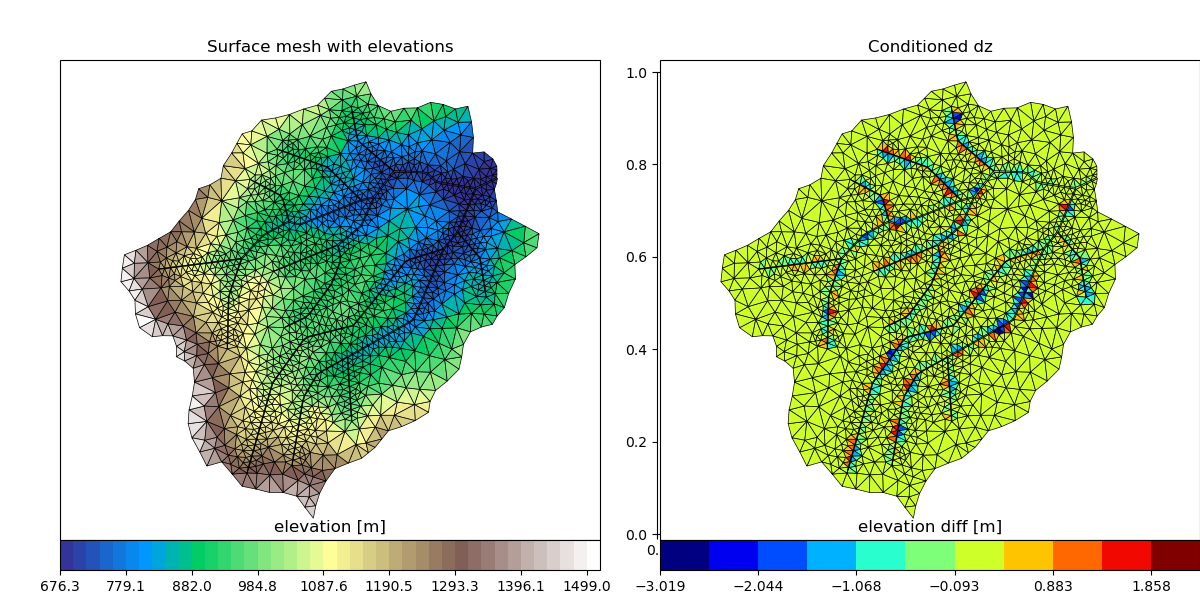

In [46]:
start=min(m2_unconditioned.centroids[:,2])
step=(max(m2_unconditioned.centroids[:,2])-(min(m2_unconditioned.centroids[:,2])))/40
stop=max(m2_unconditioned.centroids[:,2])+step
legend_values=np.arange(start,stop,step)
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(legend_values, cmap='terrain')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*figsize[0], figsize[1]))

# First subplot - unconditioned mesh
ax1 = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.45,0.8])
cbax1 = fig.add_axes([0.05,0.05,0.45,0.05])

mp1 = watershed_workflow.plot.mesh(m2_unconditioned, crs, ax=ax1, 
                        linewidth=0.5 ,color=m2_unconditioned.centroids[:,2], 
                        cmap=cmap, norm = norm, edgecolor='k', facecolor='color')
cbar1 = fig.colorbar(mp1, orientation="horizontal", cax=cbax1)
ax1.set_title('Surface mesh with elevations')
ax1.set_aspect('equal', 'datalim')
cbar1.ax.set_title('elevation [m]')

# Second subplot - elevation difference
diff = m2.centroids[:,2] - m2_unconditioned.centroids[:,2]
print("max diff = ", np.abs(diff).max())

start=min(diff)
step=(max(diff)-(min(diff)))/10
stop=max(diff)+step
legend_values=np.arange(start,stop,step)
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(legend_values, cmap='jet')

ax2 = watershed_workflow.plot.get_ax(crs, fig, window=[0.55,0.1,0.45,0.8])
cbax2 = fig.add_axes([0.55,0.05,0.45,0.05])

mp2 = watershed_workflow.plot.mesh(m2, crs, ax=ax2,
                        linewidth=0.5 ,color=diff,
                        cmap=cmap, norm = norm, edgecolor='k', facecolor='color')
cbar2 = fig.colorbar(mp2, orientation="horizontal", cax=cbax2)
ax2.set_title('Conditioned dz')
ax2.set_aspect('equal', 'datalim')
cbar2.ax.set_title('elevation diff [m]')

plt.show()

### 2) Uniform Supplemental Depth

In [52]:
## get the original mesh
m2 = copy.deepcopy(m2_unconditioned)
## propogate the depth from headwaters
watershed_workflow.condition.condition_river_mesh(m2, rivers[0], network_burn_in_depth=1)

/Users/7s2/opt/anaconda3/envs/watershed_workflow-pure/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0.5, 'cmap': <matplotlib.colors.ListedColormap object at 0x30fa660e0>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x30fa65cc0>, 'edgecolor': 'k'}
setting face color =  [1341.90253697  692.39893454  777.7524677  ...  876.71130111  888.3478981
  896.01467586]
max diff =  3.765805586310421
kwargs =  {'linewidth': 0.5, 'cmap': <matplotlib.colors.ListedColormap object at 0x30fd96a40>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x30fd96b30>, 'edgecolor': 'k'}
setting face color =  [-0.33341597  0.23240911  0.         ... -3.13225942 -3.13108985
 -0.99888374]


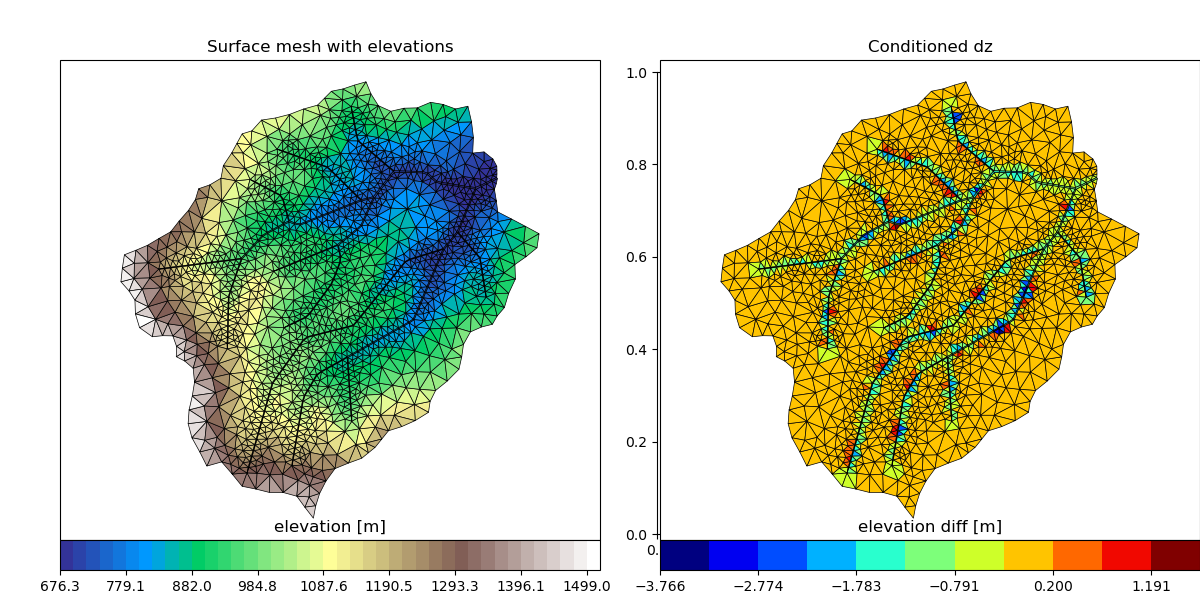

In [53]:
start=min(m2_unconditioned.centroids[:,2])
step=(max(m2_unconditioned.centroids[:,2])-(min(m2_unconditioned.centroids[:,2])))/40
stop=max(m2_unconditioned.centroids[:,2])+step
legend_values=np.arange(start,stop,step)
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(legend_values, cmap='terrain')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*figsize[0], figsize[1]))

# First subplot - unconditioned mesh
ax1 = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.45,0.8])
cbax1 = fig.add_axes([0.05,0.05,0.45,0.05])

mp1 = watershed_workflow.plot.mesh(m2_unconditioned, crs, ax=ax1, 
                        linewidth=0.5 ,color=m2_unconditioned.centroids[:,2], 
                        cmap=cmap, norm = norm, edgecolor='k', facecolor='color')
cbar1 = fig.colorbar(mp1, orientation="horizontal", cax=cbax1)
ax1.set_title('Surface mesh with elevations')
ax1.set_aspect('equal', 'datalim')
cbar1.ax.set_title('elevation [m]')

# Second subplot - elevation difference
diff = m2.centroids[:,2] - m2_unconditioned.centroids[:,2]
print("max diff = ", np.abs(diff).max())

start=min(diff)
step=(max(diff)-(min(diff)))/10
stop=max(diff)+step
legend_values=np.arange(start,stop,step)
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(legend_values, cmap='jet')

ax2 = watershed_workflow.plot.get_ax(crs, fig, window=[0.55,0.1,0.45,0.8])
cbax2 = fig.add_axes([0.55,0.05,0.45,0.05])

mp2 = watershed_workflow.plot.mesh(m2, crs, ax=ax2,
                        linewidth=0.5 ,color=diff,
                        cmap=cmap, norm = norm, edgecolor='k', facecolor='color')
cbar2 = fig.colorbar(mp2, orientation="horizontal", cax=cbax2)
ax2.set_title('Conditioned dz')
ax2.set_aspect('equal', 'datalim')
cbar2.ax.set_title('elevation diff [m]')

plt.show()

### Function-based Supplemental Depth

In [54]:
# Depth vs Drainage area scaling for Tenessee streams 
# (source: https://www.tn.gov/content/dam/tn/environment/water/natural-resources-unit/wr_nru_tennessee-ref-stream-morphology.pdf)
def depth_drainage_area_scaling(DA):
    DA_sq_miles =  DA/2589988.11   
    depth_in_feet = 1.22*DA_sq_miles**0.317
    return 0.3048*depth_in_feet # depth_in_meters

In [59]:
## get the original mesh
m2 = copy.deepcopy(m2_unconditioned)
watershed_workflow.condition.condition_river_mesh(m2, rivers[0], network_burn_in_depth=depth_drainage_area_scaling)

kwargs =  {'linewidth': 0.5, 'cmap': <matplotlib.colors.ListedColormap object at 0x31b1715d0>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x31b2c6710>, 'edgecolor': 'k'}
setting face color =  [1341.90253697  692.39893454  777.7524677  ...  876.71130111  888.3478981
  896.01467586]
max diff =  3.1902735127589494
kwargs =  {'linewidth': 0.5, 'cmap': <matplotlib.colors.ListedColormap object at 0x31e9b5cc0>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x31e9b5de0>, 'edgecolor': 'k'}
setting face color =  [-0.09390852  0.39368417  0.         ... -2.38447762 -2.38330806
 -0.25110194]


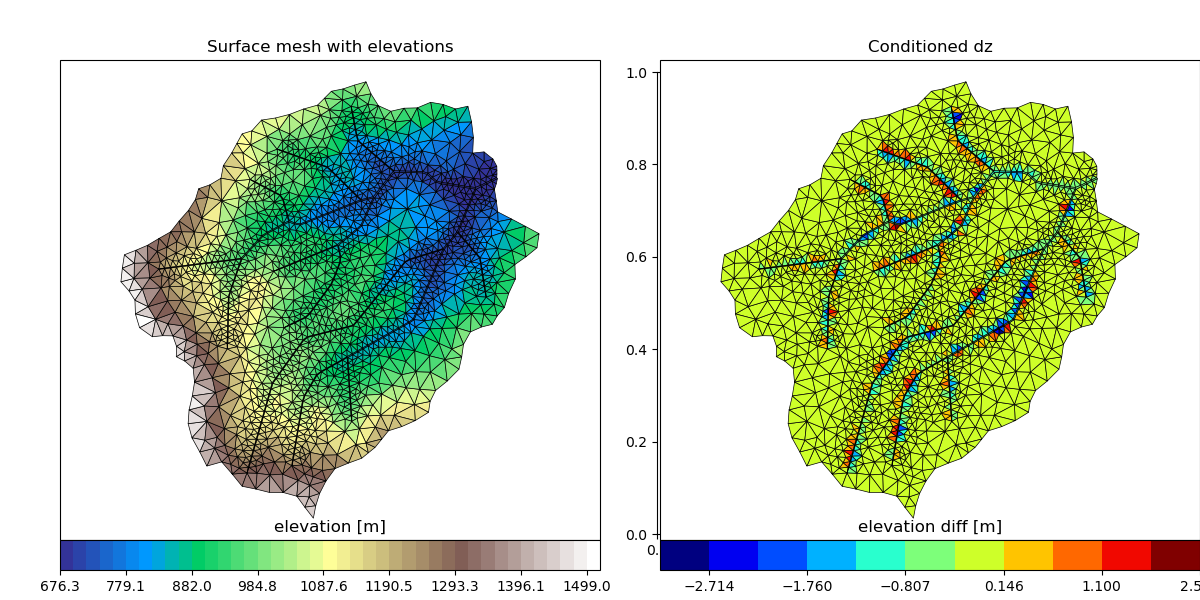

In [60]:
start=min(m2_unconditioned.centroids[:,2])
step=(max(m2_unconditioned.centroids[:,2])-(min(m2_unconditioned.centroids[:,2])))/40
stop=max(m2_unconditioned.centroids[:,2])+step
legend_values=np.arange(start,stop,step)
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(legend_values, cmap='terrain')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*figsize[0], figsize[1]))

# First subplot - unconditioned mesh
ax1 = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.45,0.8])
cbax1 = fig.add_axes([0.05,0.05,0.45,0.05])

mp1 = watershed_workflow.plot.mesh(m2_unconditioned, crs, ax=ax1, 
                        linewidth=0.5 ,color=m2_unconditioned.centroids[:,2], 
                        cmap=cmap, norm = norm, edgecolor='k', facecolor='color')
cbar1 = fig.colorbar(mp1, orientation="horizontal", cax=cbax1)
ax1.set_title('Surface mesh with elevations')
ax1.set_aspect('equal', 'datalim')
cbar1.ax.set_title('elevation [m]')

# Second subplot - elevation difference
diff = m2.centroids[:,2] - m2_unconditioned.centroids[:,2]
print("max diff = ", np.abs(diff).max())

start=min(diff)
step=(max(diff)-(min(diff)))/10
stop=max(diff)+step
legend_values=np.arange(start,stop,step)
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(legend_values, cmap='jet')

ax2 = watershed_workflow.plot.get_ax(crs, fig, window=[0.55,0.1,0.45,0.8])
cbax2 = fig.add_axes([0.55,0.05,0.45,0.05])

mp2 = watershed_workflow.plot.mesh(m2, crs, ax=ax2,
                        linewidth=0.5 ,color=diff,
                        cmap=cmap, norm = norm, edgecolor='k', facecolor='color')
cbar2 = fig.colorbar(mp2, orientation="horizontal", cax=cbax2)
ax2.set_title('Conditioned dz')
ax2.set_aspect('equal', 'datalim')
cbar2.ax.set_title('elevation diff [m]')

plt.show()